In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from skimpy import skim

In [3]:
from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter
from lifelines.statistics import logrank_test, pairwise_logrank_test

In [96]:
from sksurv.datasets import get_x_y
from sksurv.metrics import integrated_brier_score
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis

In [24]:
FIG_SIZE = (20, 10)
plt.rcParams.update({'figure.figsize': FIG_SIZE})   

In [25]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [26]:
df['churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [27]:
kmf = KaplanMeierFitter()
kmf.fit(df['tenure'], df['churn'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7043 total observations, 5174 right-censored observations>

Text(0.5, 1.0, 'Kaplan-Meier Curve')

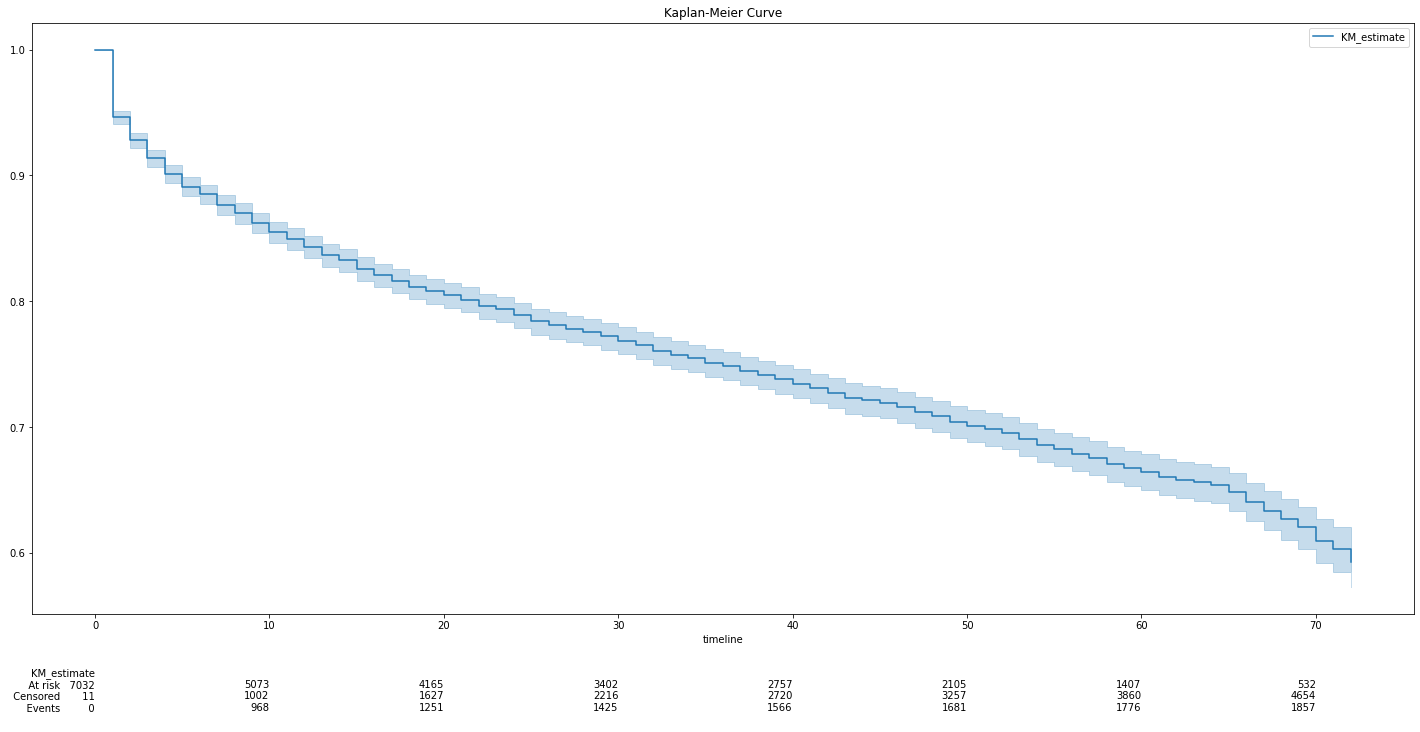

In [28]:
kmf.plot(at_risk_counts=True)
plt.title('Kaplan-Meier Curve')

In [29]:
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

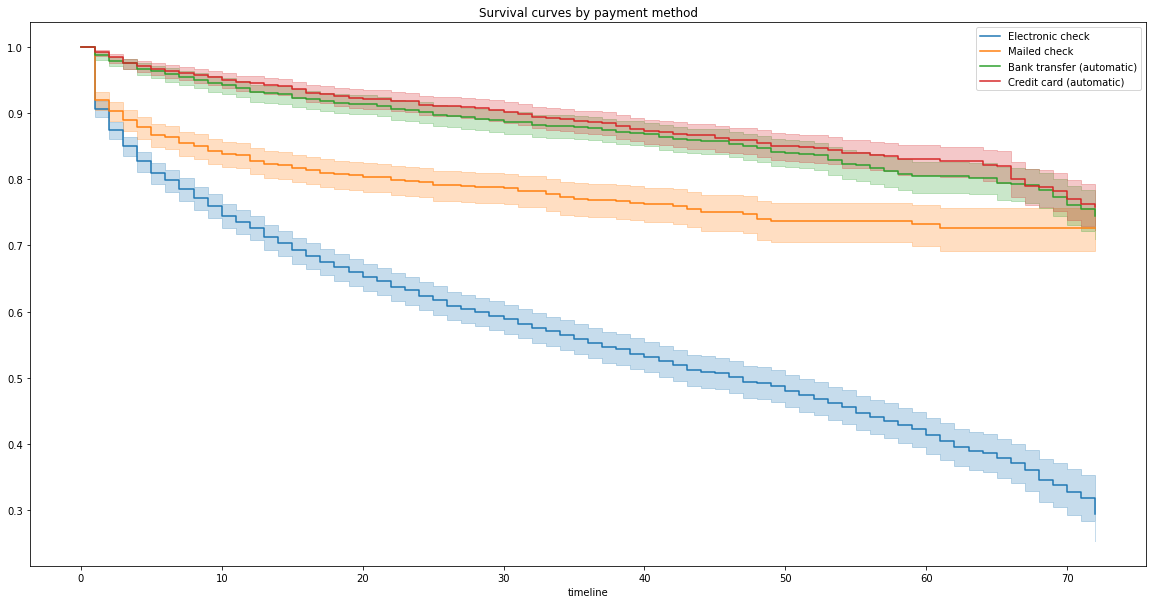

In [30]:
ax = plt.subplot()

for method in df['PaymentMethod'].unique():
    condition = df['PaymentMethod'] == method
    
    kmf = KaplanMeierFitter()
    kmf.fit(df.loc[condition, 'tenure'], df.loc[condition, 'churn'], label=method)
    kmf.plot(ax=ax)
    
plt.title("Survival curves by payment method");

In [31]:
credit_card = df['PaymentMethod'] == 'Credit card (automatic)'
bank_transfer = df['PaymentMethod'] == 'Bank transfer (automatic)'

In [32]:
results = logrank_test(df.loc[credit_card, 'tenure'],
                       df.loc[bank_transfer, 'tenure'],
                       df.loc[credit_card, 'churn'],
                       df.loc[bank_transfer, 'churn'])

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.87 0.35      1.51

In [33]:
results = pairwise_logrank_test(df['tenure'], df['PaymentMethod'], df['churn'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                                   test_statistic      p  -log2(p)
Bank transfer (automatic) Credit card (automatic)            0.87   0.35      1.51
                          Electronic check                 510.04 <0.005    372.74
                          Mailed check                      51.07 <0.005     40.03
Credit card (automatic)   Electronic check                 539.74 <0.005    394.21
                          Mailed check                      64.82 <0.005     50.11
Electronic check          Mailed check                     152.46 <0.005    113.93

Text(0.5, 1.0, 'Cumulative hazard function')

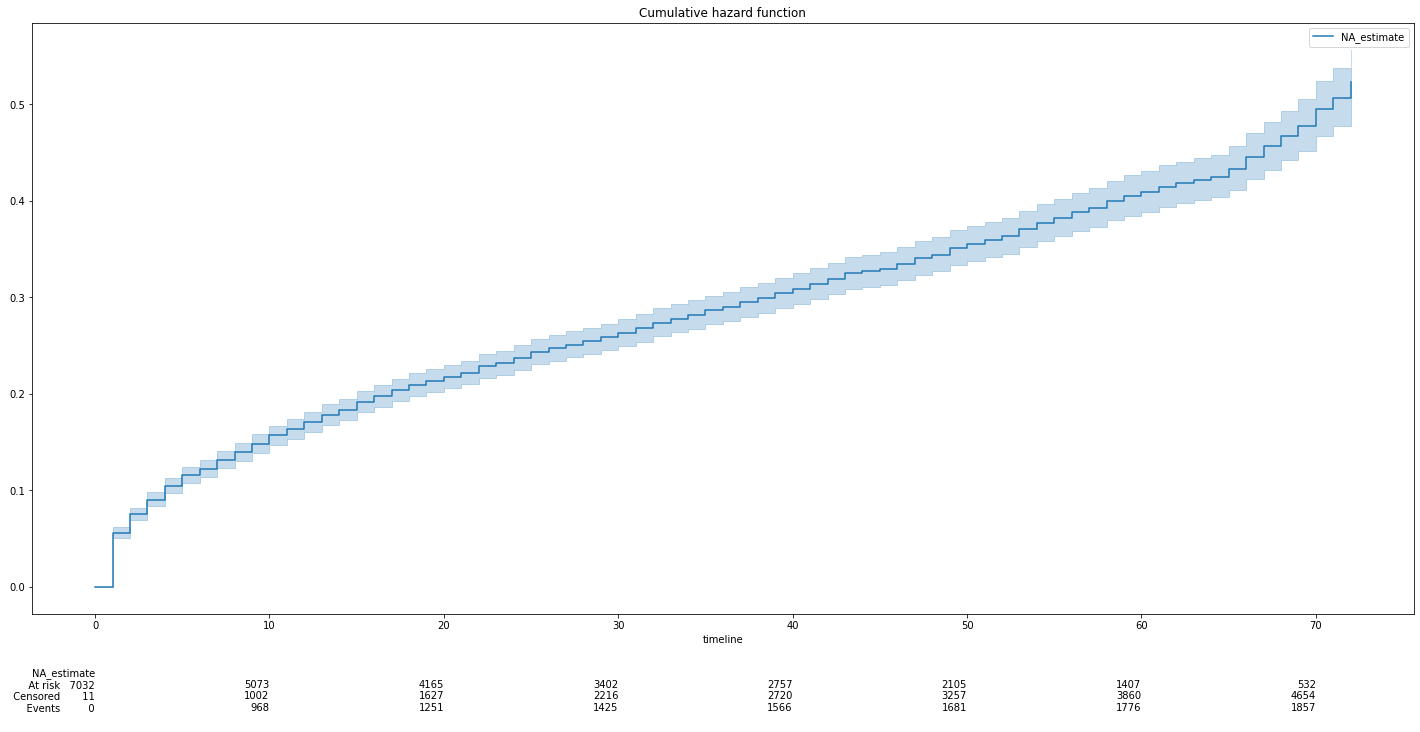

In [34]:
naf = NelsonAalenFitter()
naf.fit(df['tenure'], df['churn'])

naf.plot(at_risk_counts=True)
plt.title('Cumulative hazard function')

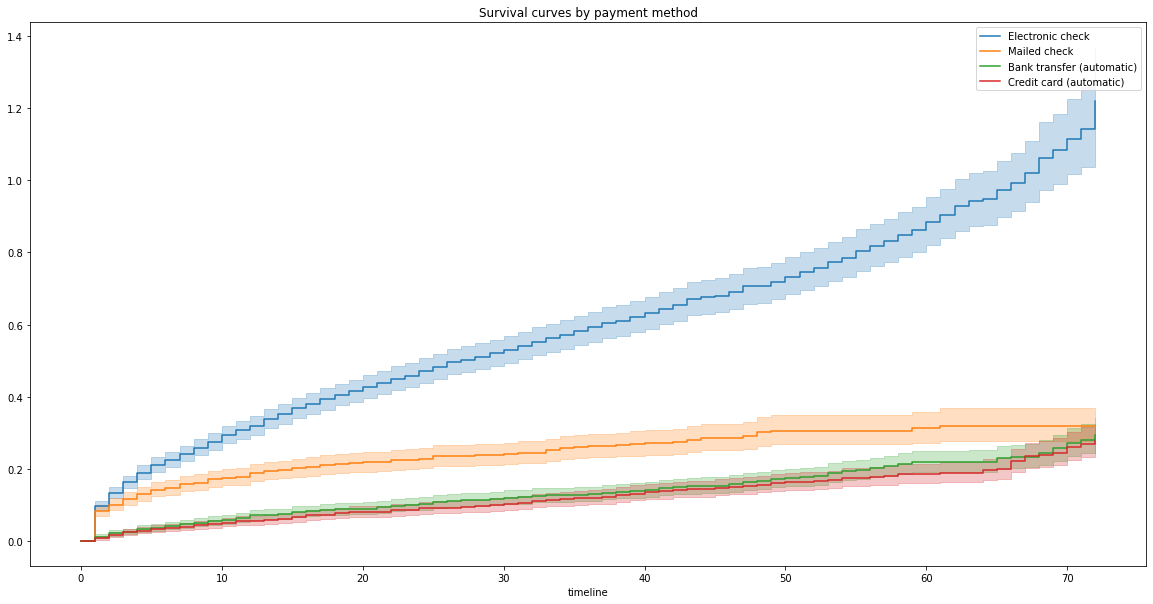

In [35]:
ax = plt.subplot()

for method in df['PaymentMethod'].unique():
    condition = df['PaymentMethod'] == method
    
    naf = NelsonAalenFitter()
    naf.fit(df.loc[condition, 'tenure'], df.loc[condition, 'churn'], label=method)
    naf.plot(ax=ax)
    
plt.title("Survival curves by payment method");

In [36]:
df = pd.get_dummies(df.loc[:, ['gender', 'SeniorCitizen', 'Partner','tenure', 'churn', 'PhoneService', 'OnlineSecurity', 'Contract']], drop_first=True)
df_train, df_test =  df.iloc[:-10], df.iloc[-10:]

In [37]:
cph = CoxPHFitter()
cph.fit(df_train, duration_col='tenure', event_col='churn')

<lifelines.CoxPHFitter: fitted with 7033 total observations, 5166 right-censored observations>

In [38]:
cph.print_summary(columns=["coef","exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%", "z", "p"], decimals=3)

<lifelines.CoxPHFitter: fitted with 7033 total observations, 5166 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 7033
number of events observed = 1867
   partial log-likelihood = -14141.867
         time fit was run = 2022-07-23 18:00:29 UTC

---
                                     coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%       z       p
covariate                                                                                                     
SeniorCitizen                      -0.034      0.966                0.869                1.075  -0.633   0.527
gender_Male                        -0.056      0.945                0.863                1.035  -1.218   0.223
Partner_Yes                        -0.615      0.541                0.490                0.596 -12.341 <0.0005
PhoneService_Yes                    0.169      1.184                1.011                1.388   2.092   0.036
OnlineSecurity_No internet service -0.747      0.474                0.389                0.577  -7.411 <0.0005
OnlineSecurity_Yes                 -0.786      0.456                0.401                0.518 -12.026 <0.0005
Contract_One year                  -1.966      0.140                0.118                0.165 -23.072 <0.0005
Contract_Two year                  -3.774      0.023                0.017                0.031 -23.470 <0.0005
---
Concordance = 0.829
Partial AIC = 28299.733
log-likelihood ratio test = 2985.035 on 8 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

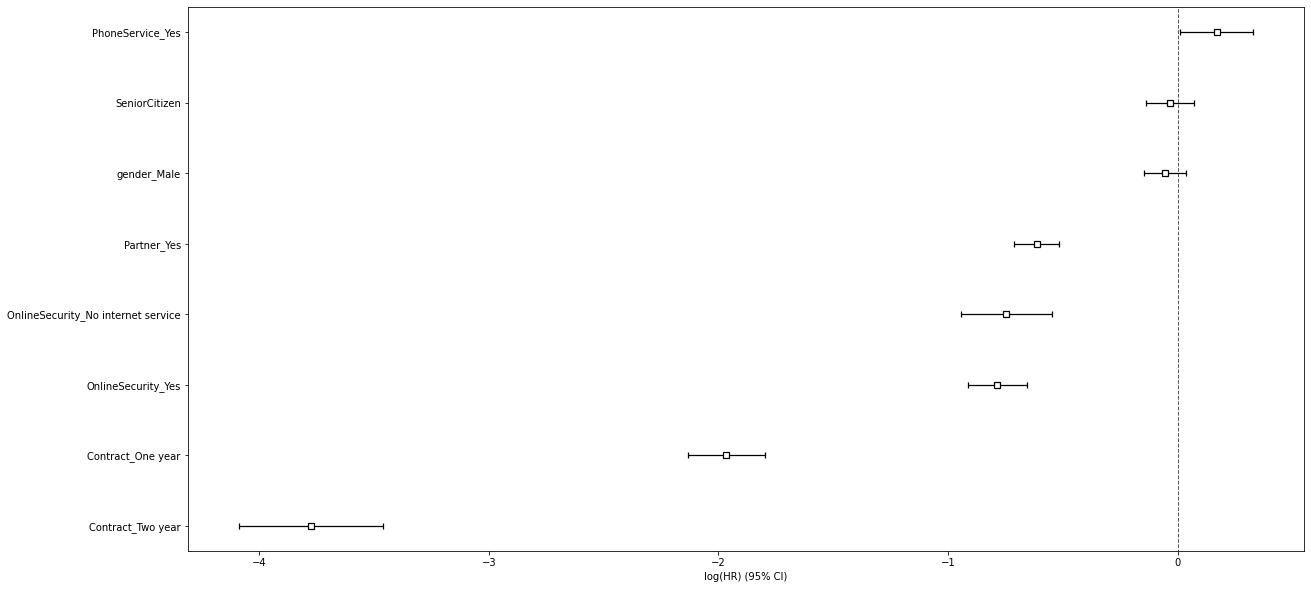

In [39]:
cph.plot()

In [40]:
forecast = cph.predict_survival_function(df_test)

<AxesSubplot:>

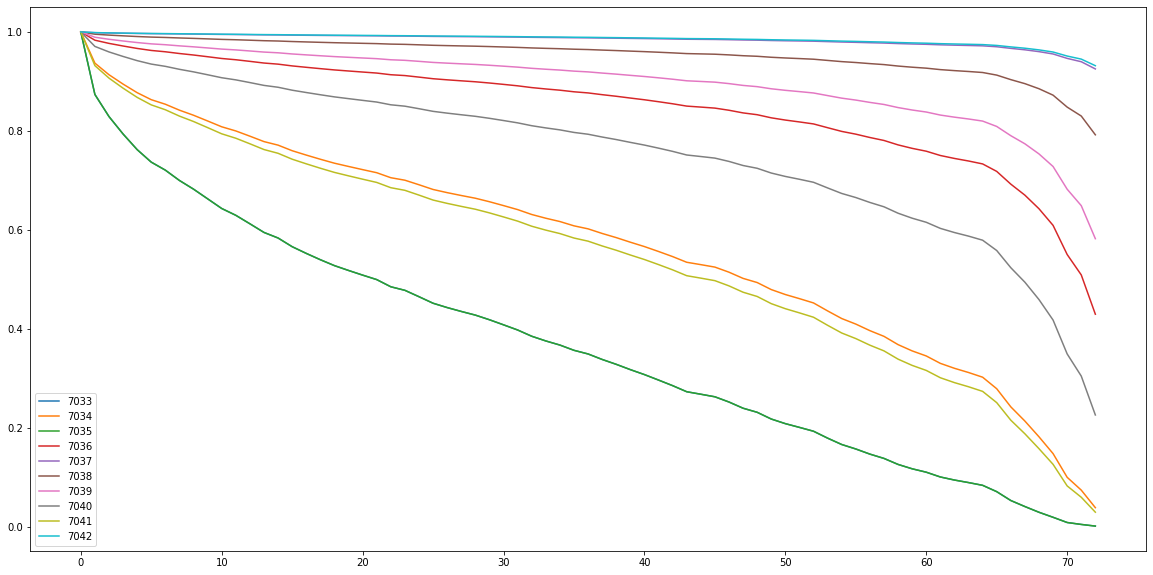

In [41]:
forecast.plot()

<AxesSubplot:>

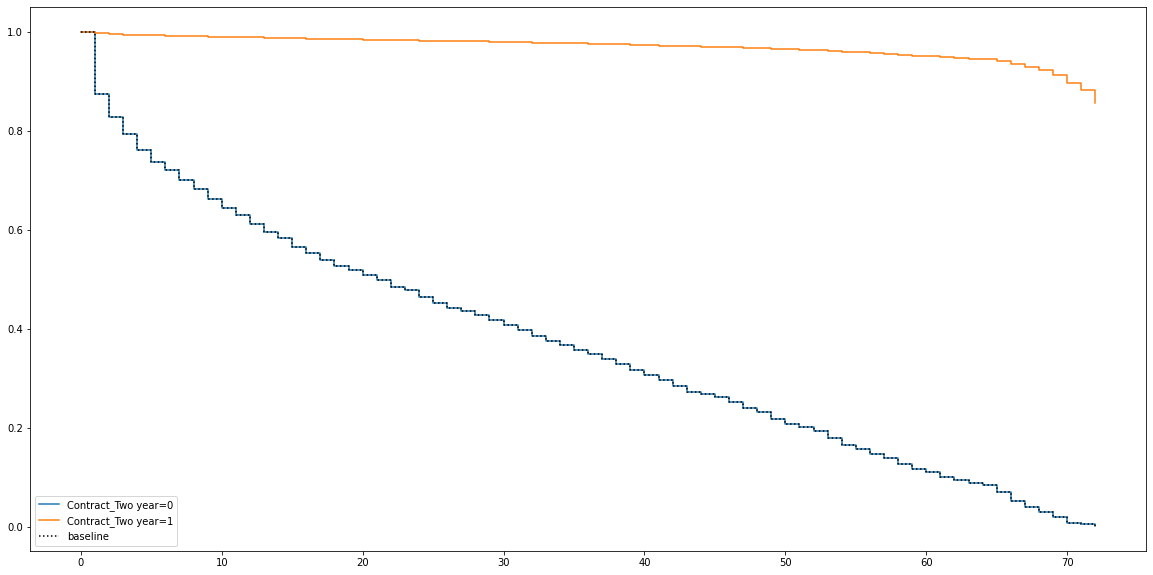

In [42]:
cph.plot_partial_effects_on_outcome('Contract_Two year', values=[0, 1])

In [89]:
x_train, y_train = get_x_y(df_train, ['churn', 'tenure'], pos_label=1)
x_test, y_test = get_x_y(df_test, ['churn', 'tenure'], pos_label=1)

In [94]:
est = RandomSurvivalForest()
est.fit(x_train, y_train)

RandomSurvivalForest()

In [95]:
est.score(x_test, y_test)

0.8181818181818182

In [158]:
times = np.arange(pd.DataFrame(y_test).iloc[:, 1].min(), pd.DataFrame(y_test).iloc[:, 1].max())
preds = np.array([[fn(t) for t in times] for fn in est.predict_survival_function(x_test)])

integrated_brier_score(y_train, y_test, 
                       preds,
                       times
                      )

0.11532118082475785

In [160]:
est = GradientBoostingSurvivalAnalysis()
est.fit(x_train, y_train)

GradientBoostingSurvivalAnalysis()

In [161]:
est.score(x_test, y_test)

0.8181818181818182

In [162]:
times = np.arange(pd.DataFrame(y_test).iloc[:, 1].min(), pd.DataFrame(y_test).iloc[:, 1].max())
preds = np.array([[fn(t) for t in times] for fn in est.predict_survival_function(x_test)])

integrated_brier_score(y_train, y_test, 
                       preds,
                       times
                      )

0.10842132943998349